# Covid X-Ray Diagnosis
## Machine Learning Final Project
### Enver Kapetanovic & Adrien Ventugol 
### Group 15

In [1]:
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import sklearn
import imblearn

In [2]:
#First import the paths of the pictures that we created with DataProcessor.ipynb
paths = pd.read_csv("paths.csv")
paths.head()

,image_path,Test
0,data_upload_v2/test/covid/03BF7561-A9BA-4C3C-B...,1
1,data_upload_v2/test/covid/1-s2.0-S014067362030...,1
2,data_upload_v2/test/covid/1-s2.0-S092966462030...,1
3,data_upload_v2/test/covid/1-s2.0-S092966462030...,1
4,data_upload_v2/test/covid/1-s2.0-S092966462030...,1


In [3]:
#initiate the list we will use to first store the pixel data, then pass into the dataframe.
pixel_data = []

In [4]:
#define a function to use as a lambda function in DataFrame.apply()
def to_pixel(row):
    color_img = Image.open(row["image_path"])
    resized = color_img.resize((50, 50), Image.BICUBIC) #Bicubic/Nearest resample give the best results
    sharpened = ImageEnhance.Sharpness(resized).enhance(1.5)
    contrasted = ImageEnhance.Contrast(sharpened).enhance(1.1)
    gray_img = ImageOps.grayscale(contrasted)
    pixel_data.append(np.asarray(gray_img).flatten().tolist()) #convert image to numpy array, flatten it, convert to list
    color_img.close()
    # pixel data now has the complete data of another picture at pixel_data[-1]

In [5]:
#apply the lambda function to all the rows of the paths dataframe
paths.apply(lambda row: to_pixel(row), axis = 1)

#Separate Data into X and y
y = paths.loc[0:,'Test']
X = pd.DataFrame(data = pixel_data)

In [6]:
#check X set
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,40,52,68,41,37,37,36,34,58,76,...,179,179,179,182,186,184,180,175,163,153
1,50,56,60,67,69,74,89,87,89,107,...,92,113,120,148,151,129,120,109,95,82
2,68,163,35,0,4,4,3,3,3,3,...,131,125,123,97,61,34,14,0,1,3
3,118,44,0,0,0,0,0,0,0,0,...,142,114,50,10,0,0,0,0,0,15
4,47,123,22,0,0,0,0,0,0,0,...,174,156,144,88,33,3,0,0,0,0


In [7]:
#check y
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Test, dtype: int64

In [8]:
#Train/test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, train_size=.8, random_state=0)

In [9]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

#Normalize X using mean normalization. Minmax could partly negate the difference we've introduced earlier.
X_norm = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

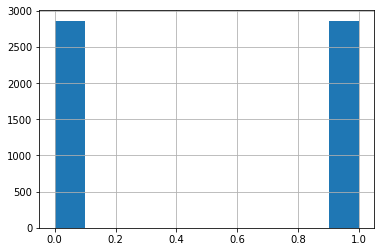

In [10]:
#Imbalanced Data, Solve with Random Over Sampling Technique
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 3)

#In this current setup, oversampling reduces the number of False Negatives.
X_train,y_train = ros.fit_resample(X_norm,y_train)
y_train.hist()

In [11]:
from sklearn.naive_bayes import BernoulliNB
import sklearn.metrics as sk_mtrx

In [12]:
#train the model
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB()

test set:
recall score:		[0.97493036 0.91428571]
balanced accuracy score: 0.944608038201353
 confusion matrix:
[[700  18]
 [  3  32]]
f1 score: 		0.7529411764705883


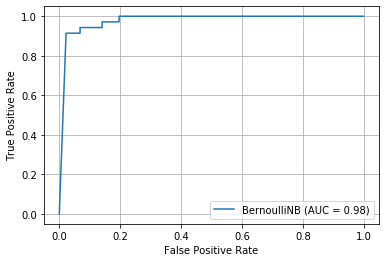

In [20]:
y_score_test = clf.predict(X_test)
#metrics we are interested in
av_prec = sk_mtrx.average_precision_score(y_test, y_score_test)

#for this model we are particularly interested in maximizing recall at the detriment of precision
recall = sk_mtrx.recall_score(y_test, y_score_test, average = None)
bal_acc = sk_mtrx.balanced_accuracy_score(y_test,y_score_test)
conf = sk_mtrx.confusion_matrix(y_test, y_score_test)
f1 = sk_mtrx.f1_score(y_test, y_score_test)


print("test set:")
print(("recall score:\t\t{0}\nbalanced accuracy score: {1}\n confusion matrix:\n{2}\n"+
"f1 score: \t\t{3}").format(recall, bal_acc, conf,f1))


sk_mtrx.plot_roc_curve(clf, X_test, y_test)
plt.grid()

Text(0.5, 1.0, '2-class Precision-Recall curve:Average Precision =0.59')

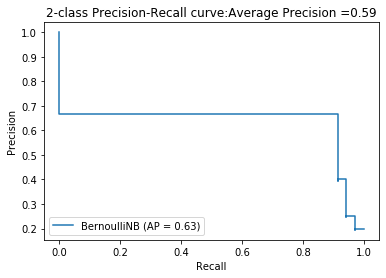

In [15]:
disp = sk_mtrx.plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve:Average Precision ={0:0.2f}'.format(av_prec))

## Let's try our model on pictures!
### Feel free to load your own pictures on the last line

In [53]:
cov = "Demo\\covid-demo.jpg"
non = "Demo\\normal-demo.jpg"

In [54]:
def test_model(path):
    pic = Image.open(path)
    pic.show()
    resized = pic.resize((50, 50), Image.BICUBIC)
    sharpened = ImageEnhance.Sharpness(resized).enhance(1.5)
    contrasted = ImageEnhance.Contrast(sharpened).enhance(1.1)
    gray_img = ImageOps.grayscale(contrasted)
    covid_pixels = np.asarray(gray_img).flatten()
    pic.close()
    covid_pixels = pd.DataFrame(data = covid_pixels).transpose()
    covid_pixels = std_scaler.transform(covid_pixels)
    if clf.predict(covid_pixels)[0] == 1:
        print("The patient has covid.")
    else:
        print("The patient does not have covid.")

In [55]:
for pic in [cov,non]:
    test_model(pic)

The patient has covid.
The patient does not have covid.


In [ ]:
#Your turn!
test_model(...)